MeshNet architecture based on https://arxiv.org/pdf/1612.00940.pdf

"End-to-end learning of brain tissue segmentation
from imperfect labeling"
Jun 2017
Alex Fedorov∗†, Jeremy Johnson‡
, Eswar Damaraju∗†, Alexei Ozerin§
, Vince Calhoun∗†, Sergey Plis∗†

In [1]:
!ls
#!ls ./stage1_train

datalab				  stage1_test	   stage1_train_labels.csv.zip
Drive				  stage1_test.zip  stage1_train.zip
stage1_sample_submission.csv.zip  stage1_train


In [0]:
# https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab

#### FIRST WE SHALL FUSE THE DRIVE
#### CUZ THATS WHAT YOU DO ON 

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p Drive
!google-drive-ocamlfuse My Drive

# Navigate to our project directory
import os
#os.chdir('/content/Drive/Data Science Bowl 2018')


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#import os
#os.mknod('/content/Drive/Data Science Bowl 2018/mynewnod.txt') # This works
os.listdir()

['datalab',
 'Drive',
 '.ipython',
 '.config',
 '.forever',
 '.rnd',
 '.gdfuse',
 '.cache',
 '.local']

# Libraries and Global Parameters 

In [0]:
# Remember to turn on GPU!!!

# installing packages
!pip install keras
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install kaggle-cli


    100% |████████████████████████████████| 337kB 2.3MB/s 
Selecting previously unselected package libxext6:amd64.
(Reading database ... 18106 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: c

    100% |████████████████████████████████| 102kB 8.6MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - \ done
  Stored in directory: /content/.cache/pip/wheels/f0/3c/ff/c98870eeb0ca26250ce6a60dc9be23f547b7ef68b3d6a1c0b5
  Running setup.py bdist_wheel for cliff ... - done
  Stored in directory: /content/.cache/pip/wheels/27/4c/aa/0f67aa384e67aacc5629321b1a3f85892362d4e9e5cd3a20f1
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /content/.cache/pip/wheels/1c/bd/b4/277af3f6c40645661b4cd1c21df26aca0f2e1e9714a1d4cda8
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /content/.cache/pip/wheels/b6/90/7b/1c22b89217d0eba6d5f406e562365ebee804f0d4595b2bdbcd
  Running setup.py bdist_wheel for cmd2 ... - done
  Stored in directory: /content/.cache/pip/wheels/c2/72/23/369d3079bb5c0abe681a237b862aac1f75035876fa156edfd7
  Running setup.py bdist_wheel for pyperclip ... - done
  Stored in directory: /content/.cache/pip

In [0]:
# Download our data straight from Kaggle
!kg download -u "xxx" -p "xxx" -c data-science-bowl-2018 

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_sample_submission.csv.zip

stage1_sample_submission.csv.zip 100% |#############| Time: 0:00:00  10.5 KiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_train_labels.csv.zip

stage1_train_labels.csv.zip 100% |##################| Time: 0:00:00   7.5 MiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_test.zip

stage1_test.zip 100% |##############################| Time: 0:00:00  17.9 MiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_train.zip

stage1_train.zip 100% |#############################| Time: 0:00:01  43.9 MiB/s



In [0]:
# Unzip the data
!unzip -q stage1_train.zip -d stage1_train
!unzip -q stage1_test.zip -d stage1_test

In [0]:
# Look at our files
os.chdir('/content')
os.listdir()

['datalab',
 'Drive',
 '.ipython',
 '.config',
 '.kaggle-cli',
 '.forever',
 'stage1_sample_submission.csv.zip',
 'stage1_train.zip',
 '.rnd',
 'stage1_train_labels.csv.zip',
 '.gdfuse',
 'stage1_test.zip',
 'stage1_train',
 '.cache',
 'stage1_test',
 '.local']

In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 1

#############################
#############################

model_checkpoint_file= 'augmesh_v' + str(model_num) +'.h5'
submission_filename = 'augmesh_v' + str(model_num) +'.csv'

# Change directory
os.chdir('/content/Drive/Data Science Bowl 2018')

# Root folders for test and training data
# Use data in /content since google drive fuse I/O speeds are slow
train_root = "/content/stage1_train"
test_root = "/content/stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

Using TensorFlow backend.


# Preparing the Data

In [3]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
    print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, filenames, dirs

train_X, train_filenames, train_dirs = import_images(train_root)

0.16090279665693347
0.24962165076888504
6.61494076761735e-16
1.0000000000000002
float64
float64
float64


In [0]:
np.finfo(np.longdouble)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [0]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

Image #: 390


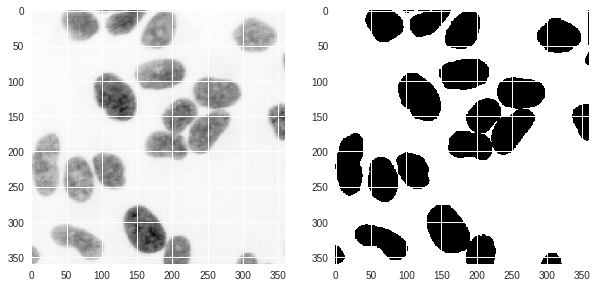

In [0]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])

    plt.show()
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)
    

plot_check([train_images,train_masks],rand_imgs=1,size=(10,7))


In [0]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 66


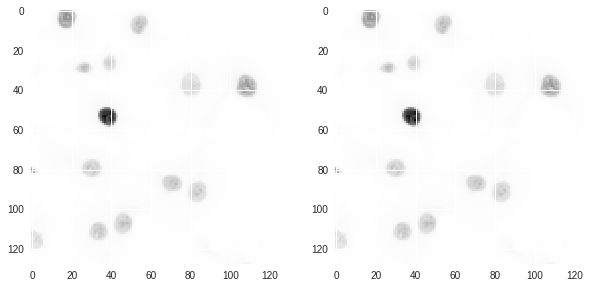

In [0]:
plot_check([resized_train_images,np.squeeze(train_X,axis=3)],rand_imgs=1,size=(10,7))

# Now Let's Build the Model

In [0]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate) (x)
   # x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout_rate=0.2
):
    
    inputs = Input(input_shape)
    
    # Does this help with computation?? 

    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

my_model = get_net(nb_filters=21,dropout_rate=0.1,loss=binary_crossentropy)

############################################################################

print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 21)      210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 21)      3990      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 21)      3990      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128, 21)      0         
__________

In [0]:
os.listdir()

['MeshNet V15 - Colab Test.ipynb',
 'U-net V3.ipynb',
 'U-net V4 (laptop test).ipynb',
 'unet_v4.h5',
 'U-net V1.ipynb',
 'U-net V2 (no dilation).ipynb',
 'Reference Code',
 '.gitignore',
 'MeshNet V17.ipynb',
 'MeshNet V18.ipynb',
 'MeshNet V19.ipynb',
 'MeshNet V16.ipynb',
 'MeshNet V15.ipynb',
 'MeshNet V13.ipynb',
 'MeshNet V10.ipynb',
 'MeshNet V11.ipynb',
 'MeshNet V14.ipynb',
 'MeshNet V8.ipynb',
 'MeshNet V9.ipynb',
 'Notes.txt',
 'MeshNet V12.ipynb',
 'Image Pre-processing and Augmentation.ipynb',
 'Post Analysis.ipynb',
 'MeshNet V7.ipynb',
 '.git',
 'meshnet_v7.h5',
 'Stock U-net.ipynb',
 '.ipynb_checkpoints',
 'Archive',
 'dtype scaling testing.ipynb',
 'ipythonnotebooks',
 'Pure Image Processing - OpenCV.ipynb',
 'model-dsbowl2018-batchnorm.h5',
 'sub-dsbowl2018_batchNorm.csv',
 'sub-dsbowl2018-1.csv',
 'sub-dsbowl2018-1_stockUnet.csv',
 'submission_image_processing.csv',
 'README.md',
 'stage1_sample_submission.csv',
 'sub-dsbowl2018-2.csv',
 'sub-dsbowl2018_dice.csv',
 '

In [0]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 14s 23ms/step - loss: 0.2185 - bce_dice_loss: 0.7202 - dice_coef: 0.5688 - val_loss: 0.1333 - val_bce_dice_loss: 0.4757 - val_dice_coef: 0.8128

Epoch 00001: val_loss improved from inf to 0.13326, saving model to meshnet_v15_colab.h5
Epoch 2/100
429/603 [====================>.........] - ETA: 3s - loss: 0.1216 - bce_dice_loss: 0.4084 - dice_coef: 0.8158

603/603 [==============================] - 12s 20ms/step - loss: 0.1206 - bce_dice_loss: 0.4064 - dice_coef: 0.8129 - val_loss: 0.1128 - val_bce_dice_loss: 0.3977 - val_dice_coef: 0.8139

Epoch 00002: val_loss improved from 0.13326 to 0.11277, saving model to meshnet_v15_colab.h5
Epoch 3/100
603/603 [==============================] - 12s 20ms/step - loss: 0.1035 - bce_dice_loss: 0.3475 - dice_coef: 0.8341 - val_loss: 0.1035 - val_bce_dice_loss: 0.3320 - val_dice_coef: 0.8361

Epoch 00003: val_loss improved from 0.11277 to 0.10348, saving model to meshnet_v15_colab.h5
Epoch 4/100
 46/603 [=>............................] - ETA: 10s - loss: 0.1080 - bce_dice_loss: 0.3710 - dice_coef: 0.8250

603/603 [==============================] - 12s 19ms/step - loss: 0.0971 - bce_dice_loss: 0.3275 - dice_coef: 0.8431 - val_loss: 0.0914 - val_bce_dice_loss: 0.3122 - val_dice_coef: 0.8597

Epoch 00004: val_loss improved from 0.10348 to 0.09136, saving model to meshnet_v15_colab.h5
Epoch 5/100
589/603 [============================>.] - ETA: 0s - loss: 0.0953 - bce_dice_loss: 0.3170 - dice_coef: 0.8462

603/603 [==============================] - 12s 20ms/step - loss: 0.0955 - bce_dice_loss: 0.3185 - dice_coef: 0.8457 - val_loss: 0.0875 - val_bce_dice_loss: 0.3097 - val_dice_coef: 0.8671

Epoch 00005: val_loss improved from 0.09136 to 0.08754, saving model to meshnet_v15_colab.h5
Epoch 6/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0936 - bce_dice_loss: 0.3093 - dice_coef: 0.8506 - val_loss: 0.0864 - val_bce_dice_loss: 0.2842 - val_dice_coef: 0.8701

Epoch 00006: val_loss improved from 0.08754 to 0.08645, saving model to meshnet_v15_colab.h5
Epoch 7/100
 70/603 [==>...........................] - ETA: 10s - loss: 0.0923 - bce_dice_loss: 0.2990 - dice_coef: 0.8627

603/603 [==============================] - 12s 19ms/step - loss: 0.0860 - bce_dice_loss: 0.2889 - dice_coef: 0.8583 - val_loss: 0.0832 - val_bce_dice_loss: 0.2705 - val_dice_coef: 0.8691

Epoch 00007: val_loss improved from 0.08645 to 0.08320, saving model to meshnet_v15_colab.h5
Epoch 8/100
594/603 [============================>.] - ETA: 0s - loss: 0.0881 - bce_dice_loss: 0.2933 - dice_coef: 0.8577

603/603 [==============================] - 12s 20ms/step - loss: 0.0877 - bce_dice_loss: 0.2922 - dice_coef: 0.8583 - val_loss: 0.0887 - val_bce_dice_loss: 0.2877 - val_dice_coef: 0.8677

Epoch 00008: val_loss did not improve
Epoch 9/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0825 - bce_dice_loss: 0.2778 - dice_coef: 0.8621 - val_loss: 0.0787 - val_bce_dice_loss: 0.2572 - val_dice_coef: 0.8824

Epoch 00009: val_loss improved from 0.08320 to 0.07869, saving model to meshnet_v15_colab.h5
Epoch 10/100
130/603 [=====>........................] - ETA: 9s - loss: 0.0775 - bce_dice_loss: 0.2671 - dice_coef: 0.8653

603/603 [==============================] - 12s 20ms/step - loss: 0.0825 - bce_dice_loss: 0.2759 - dice_coef: 0.8639 - val_loss: 0.0807 - val_bce_dice_loss: 0.2717 - val_dice_coef: 0.8731

Epoch 00010: val_loss did not improve
Epoch 11/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0808 - bce_dice_loss: 0.2710 - dice_coef: 0.8661 - val_loss: 0.0844 - val_bce_dice_loss: 0.2665 - val_dice_coef: 0.8682

Epoch 00011: val_loss did not improve
Epoch 12/100
 58/603 [=>............................] - ETA: 10s - loss: 0.0606 - bce_dice_loss: 0.2224 - dice_coef: 0.8819

603/603 [==============================] - 12s 20ms/step - loss: 0.0802 - bce_dice_loss: 0.2710 - dice_coef: 0.8651 - val_loss: 0.0824 - val_bce_dice_loss: 0.2465 - val_dice_coef: 0.8824

Epoch 00012: val_loss did not improve
Epoch 13/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0787 - bce_dice_loss: 0.2651 - dice_coef: 0.8696 - val_loss: 0.0811 - val_bce_dice_loss: 0.2860 - val_dice_coef: 0.8755

Epoch 00013: val_loss did not improve
Epoch 14/100
 46/603 [=>............................] - ETA: 10s - loss: 0.0821 - bce_dice_loss: 0.3224 - dice_coef: 0.8385

603/603 [==============================] - 12s 20ms/step - loss: 0.0806 - bce_dice_loss: 0.2735 - dice_coef: 0.8654 - val_loss: 0.0869 - val_bce_dice_loss: 0.2729 - val_dice_coef: 0.8664

Epoch 00014: val_loss did not improve

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 15/100
550/603 [==========================>...] - ETA: 1s - loss: 0.0728 - bce_dice_loss: 0.2452 - dice_coef: 0.8785

603/603 [==============================] - 12s 19ms/step - loss: 0.0723 - bce_dice_loss: 0.2451 - dice_coef: 0.8779 - val_loss: 0.0718 - val_bce_dice_loss: 0.2352 - val_dice_coef: 0.8904

Epoch 00015: val_loss improved from 0.07869 to 0.07181, saving model to meshnet_v15_colab.h5
Epoch 16/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0707 - bce_dice_loss: 0.2412 - dice_coef: 0.8787 - val_loss: 0.0709 - val_bce_dice_loss: 0.2340 - val_dice_coef: 0.8920

Epoch 00016: val_loss improved from 0.07181 to 0.07089, saving model to meshnet_v15_colab.h5
Epoch 17/100
 64/603 [==>...........................] - ETA: 10s - loss: 0.0770 - bce_dice_loss: 0.2371 - dice_coef: 0.8905

603/603 [==============================] - 12s 20ms/step - loss: 0.0696 - bce_dice_loss: 0.2391 - dice_coef: 0.8792 - val_loss: 0.0718 - val_bce_dice_loss: 0.2357 - val_dice_coef: 0.8892

Epoch 00017: val_loss did not improve
Epoch 18/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0694 - bce_dice_loss: 0.2385 - dice_coef: 0.8812 - val_loss: 0.0709 - val_bce_dice_loss: 0.2272 - val_dice_coef: 0.8917

Epoch 00018: val_loss improved from 0.07089 to 0.07088, saving model to meshnet_v15_colab.h5
Epoch 19/100
 40/603 [>.............................] - ETA: 11s - loss: 0.0478 - bce_dice_loss: 0.1774 - dice_coef: 0.9099

603/603 [==============================] - 12s 20ms/step - loss: 0.0693 - bce_dice_loss: 0.2366 - dice_coef: 0.8810 - val_loss: 0.0718 - val_bce_dice_loss: 0.2371 - val_dice_coef: 0.8867

Epoch 00019: val_loss did not improve
Epoch 20/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0693 - bce_dice_loss: 0.2386 - dice_coef: 0.8804 - val_loss: 0.0696 - val_bce_dice_loss: 0.2255 - val_dice_coef: 0.8911

Epoch 00020: val_loss improved from 0.07088 to 0.06960, saving model to meshnet_v15_colab.h5
Epoch 21/100
 34/603 [>.............................] - ETA: 10s - loss: 0.0536 - bce_dice_loss: 0.1968 - dice_coef: 0.8948

603/603 [==============================] - 12s 19ms/step - loss: 0.0687 - bce_dice_loss: 0.2361 - dice_coef: 0.8810 - val_loss: 0.0719 - val_bce_dice_loss: 0.2380 - val_dice_coef: 0.8887

Epoch 00021: val_loss did not improve
Epoch 22/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0686 - bce_dice_loss: 0.2363 - dice_coef: 0.8821 - val_loss: 0.0722 - val_bce_dice_loss: 0.2368 - val_dice_coef: 0.8861

Epoch 00022: val_loss did not improve
Epoch 23/100
 40/603 [>.............................] - ETA: 10s - loss: 0.0772 - bce_dice_loss: 0.2991 - dice_coef: 0.8251

603/603 [==============================] - 12s 19ms/step - loss: 0.0683 - bce_dice_loss: 0.2348 - dice_coef: 0.8819 - val_loss: 0.0691 - val_bce_dice_loss: 0.2295 - val_dice_coef: 0.8924

Epoch 00023: val_loss improved from 0.06960 to 0.06911, saving model to meshnet_v15_colab.h5
Epoch 24/100
585/603 [============================>.] - ETA: 0s - loss: 0.0670 - bce_dice_loss: 0.2326 - dice_coef: 0.8824

603/603 [==============================] - 12s 19ms/step - loss: 0.0680 - bce_dice_loss: 0.2348 - dice_coef: 0.8815 - val_loss: 0.0696 - val_bce_dice_loss: 0.2350 - val_dice_coef: 0.8915

Epoch 00024: val_loss did not improve
Epoch 25/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0678 - bce_dice_loss: 0.2338 - dice_coef: 0.8835 - val_loss: 0.0709 - val_bce_dice_loss: 0.2273 - val_dice_coef: 0.8881

Epoch 00025: val_loss did not improve

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 26/100
124/603 [=====>........................] - ETA: 9s - loss: 0.0714 - bce_dice_loss: 0.2298 - dice_coef: 0.8844

603/603 [==============================] - 12s 19ms/step - loss: 0.0662 - bce_dice_loss: 0.2295 - dice_coef: 0.8848 - val_loss: 0.0685 - val_bce_dice_loss: 0.2239 - val_dice_coef: 0.8932

Epoch 00026: val_loss improved from 0.06911 to 0.06847, saving model to meshnet_v15_colab.h5
Epoch 27/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0660 - bce_dice_loss: 0.2273 - dice_coef: 0.8859 - val_loss: 0.0683 - val_bce_dice_loss: 0.2256 - val_dice_coef: 0.8930

Epoch 00027: val_loss improved from 0.06847 to 0.06831, saving model to meshnet_v15_colab.h5


Epoch 28/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0659 - bce_dice_loss: 0.2276 - dice_coef: 0.8860 - val_loss: 0.0684 - val_bce_dice_loss: 0.2264 - val_dice_coef: 0.8931

Epoch 00028: val_loss did not improve
Epoch 29/100
603/603 [==============================] - 12s 19ms/step - loss: 0.0658 - bce_dice_loss: 0.2281 - dice_coef: 0.8857 - val_loss: 0.0683 - val_bce_dice_loss: 0.2250 - val_dice_coef: 0.8932

Epoch 00029: val_loss did not improve
Epoch 30/100
  7/603 [..............................] - ETA: 11s - loss: 0.0952 - bce_dice_loss: 0.2554 - dice_coef: 0.8880

603/603 [==============================] - 12s 19ms/step - loss: 0.0657 - bce_dice_loss: 0.2276 - dice_coef: 0.8859 - val_loss: 0.0685 - val_bce_dice_loss: 0.2219 - val_dice_coef: 0.8930

Epoch 00030: val_loss did not improve
Epoch 31/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0657 - bce_dice_loss: 0.2266 - dice_coef: 0.8861 - val_loss: 0.0685 - val_bce_dice_loss: 0.2246 - val_dice_coef: 0.8939

Epoch 00031: val_loss did not improve

Epoch 00031: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 32/100
 31/603 [>.............................] - ETA: 10s - loss: 0.0879 - bce_dice_loss: 0.2743 - dice_coef: 0.8630

603/603 [==============================] - 12s 19ms/step - loss: 0.0654 - bce_dice_loss: 0.2261 - dice_coef: 0.8870 - val_loss: 0.0683 - val_bce_dice_loss: 0.2240 - val_dice_coef: 0.8934

Epoch 00032: val_loss improved from 0.06831 to 0.06827, saving model to meshnet_v15_colab.h5
Epoch 33/100
582/603 [===========================>..] - ETA: 0s - loss: 0.0657 - bce_dice_loss: 0.2261 - dice_coef: 0.8868

603/603 [==============================] - 12s 20ms/step - loss: 0.0653 - bce_dice_loss: 0.2258 - dice_coef: 0.8866 - val_loss: 0.0682 - val_bce_dice_loss: 0.2241 - val_dice_coef: 0.8935

Epoch 00033: val_loss improved from 0.06827 to 0.06823, saving model to meshnet_v15_colab.h5
Epoch 34/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0653 - bce_dice_loss: 0.2264 - dice_coef: 0.8862 - val_loss: 0.0682 - val_bce_dice_loss: 0.2239 - val_dice_coef: 0.8937

Epoch 00034: val_loss improved from 0.06823 to 0.06823, saving model to meshnet_v15_colab.h5
Epoch 35/100
 67/603 [==>...........................] - ETA: 10s - loss: 0.0561 - bce_dice_loss: 0.2131 - dice_coef: 0.8857

603/603 [==============================] - 12s 19ms/step - loss: 0.0652 - bce_dice_loss: 0.2257 - dice_coef: 0.8866 - val_loss: 0.0681 - val_bce_dice_loss: 0.2236 - val_dice_coef: 0.8936

Epoch 00035: val_loss improved from 0.06823 to 0.06813, saving model to meshnet_v15_colab.h5

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 36/100
 34/603 [>.............................] - ETA: 10s - loss: 0.0759 - bce_dice_loss: 0.2310 - dice_coef: 0.8891

In [0]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

0.133
0.124
0.123
0.095
0.143
0.093
0.077
0.077
0.075
0.079
0.078
0.074
0.075
0.093
0.071
0.069
0.066
0.069
0.068
0.067
0.067
0.067
0.066
0.065
0.066
0.067
0.066
0.066
0.065
0.066
0.066
0.066
0.065
0.066
0.066
0.066
0.066
0.066
0.066


In [0]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, resized_test_images, \
test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


FileNotFoundError: ignored

Image #: 23


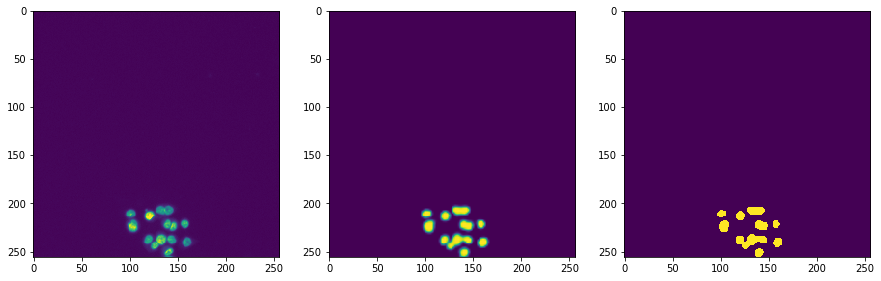

Image #: 40


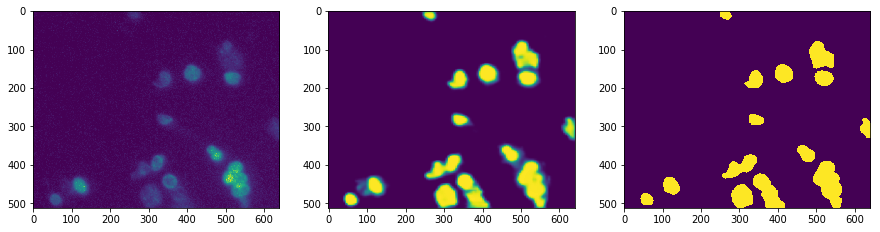

In [0]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [0]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data